# Car detection - $1^{st}$ pipeline

## Import of data, libraries and useful functions

### Libraries

In [8]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from skimage.io import imread
import cv2
import csv
import random as rd 
from skimage.feature import hog
from skimage import data, exposure
import time 

from ipywidgets import interact, widgets
from IPython.display import display
from tqdm import tqdm

import sys
sys.path.append('../utils')
from feature_extractor import *
from model import *
from helper_functions import *
from postprocess import *

### Data 

In [5]:
df_ground_truth = pd.read_csv('../data/train.csv')
df_ground_truth.head()

frame_id                                     bounding_boxes
0  train/A_001.jpg  0 225 214 317 0 172 345 254 285 240 155 131 70...
1  train/A_002.jpg  0 254 190 293 0 169 338 271 276 238 160 137 70...
2  train/A_003.jpg  0 306 59 241 0 155 306 318 235 233 191 149 713...
3  train/A_004.jpg  0 143 239 298 164 223 240 172 721 293 94 76 57...
4  train/A_005.jpg  0 217 137 270 55 209 323 208 731 296 99 79 573...

In [20]:
list_img_files = np.array(df_ground_truth.frame_id.values)
N = len(list_img_files)
h, w = 720, 1280

## Exploring training dataset 

In [9]:
def f_display(frame_id):
    show_annotation(df_ground_truth, frame_id)

interact(f_display, frame_id=widgets.IntSlider(min=0, max=N-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='frame_id', max=2221), Output()), _dom_classes=('widget-i…

<function __main__.f_display(frame_id)>

## Extract car features 

### Hog features 

In [21]:
def car_features(N, orientation = 8):
    cars_64_64 = []
    cars_128_128 = []
    for k in tqdm(range(N)):
        annotations = annotations_for_frame(df_ground_truth, k)
        img_init = imread(list_img_files[k])
        for annotation in annotations:
            img = img_init[annotation[1]:annotation[1]+annotation[3],annotation[0]:annotation[0]+annotation[2], :]
            if img.shape[0]>64 and img.shape[1]>64:
                if img.shape[1]<128 and img.shape[0]<128:
                    pixel_per_cell = 6
                    img_reshaped = cv2.resize(img,(64,64),fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
                    fd = get_hog_features_function(img_reshaped, orientation, pixel_per_cell, 1, False)
                    cars_64_64.append(fd)   
                else:
                    pixel_per_cell = 16
                    img_reshaped = cv2.resize(img,(128,128),fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
                    fd = get_hog_features_function(img_reshaped, orientation, pixel_per_cell, 1, False)
                    cars_128_128.append(fd)
    return cars_64_64, cars_128_128

In [22]:
cars_64_64, cars_128_128 = car_features( N=len(list_img_files), orientation = 8)

100%|███████████████████████████████████████| 2222/2222 [00:30<00:00, 73.09it/s]


## Extract non car features 

In [26]:
def non_car_features(N, num_boxes, box_size=64, orientation=8, pixel_per_cell=6, cell_per_block=1):
    # Radomly pick 5 frames per image of either 64*64 and 5 frames of 128*128
    non_cars_frames = []
    non_cars_features = []
    for k in tqdm(range(N)):
        annotations = annotations_for_frame(df_ground_truth, k)
        n_boxs=0
        while n_boxs<= num_boxes:
            x = rd.randint(0, w-box_size-1)
            y = rd.randint(0, h-box_size-1)
            box = [(x,y), (x+box_size, y+box_size)]
            is_overlaping=False
            for annotation in annotations:
                box_car = transform_to_bbox(annotation)
                if is_overlap(box_car, box):
                    is_overlaping=True
                    break 
            if not is_overlaping:
                n_boxs+=1
                img = imread(list_img_files[k])
                non_cars_frames.append(transform_to_annotation(box)) 
                img_non_car = img[y:y+box_size,x:x+box_size, :]
                fd = get_hog_features_function(img_non_car, orientation, pixel_per_cell, cell_per_block, False)
                non_cars_features.append(fd)       
    return non_cars_features

In [29]:
non_car_128_128 = non_car_features(N=len(list_img_files), num_boxes=5, box_size=128, orientation=8, pixel_per_cell=16, cell_per_block=1)

100%|███████████████████████████████████████| 2222/2222 [02:16<00:00, 16.32it/s]


In [30]:
non_car_64_64 = non_car_features(N=len(list_img_files), num_boxes=7)

100%|███████████████████████████████████████| 2222/2222 [03:36<00:00, 10.27it/s]


In [32]:
print(f"{len(cars_128_128)} 128*128 car features extracted")
print(f"{len(cars_64_64)} 64*64 car features extracted")

print(f"{len(non_car_features_128)} 128*128 non car features extracted")
print(f"{len(non_car_features_64)} 64*64 non car features extracted")

3994 128*128 car features extracted
1619 64*64 car features extracted
5496 128*128 non car features extracted
10076 64*64 non car features extracted


In [386]:
## Add more data for non cars and cars datasets 64*64 

In [34]:
path = "data/non-vehicles/"

for filename in os.listdir(path):
    img_non_car = imread(os.path.join(path, filename))
    fd = get_hog_features_function(img_non_car, 8, 6, 1, False)
    non_car_64_64.append(fd)

In [35]:
path = "data/vehicles/"

for filename in os.listdir(path):
    img_car = imread(os.path.join(path, filename))
    fd = get_hog_features_function(img_car, 8, 6, 1, False)
    cars_64_64.append(fd)

In [36]:
print(f"{len(cars_128_128)} 128*128 car features extracted")
print(f"{len(cars_64_64)} 64*64 car features extracted")

print(f"{len(non_car_features_128)} 128*128 non car features extracted")
print(f"{len(non_car_features_64)} 64*64 non car features extracted")

3994 128*128 car features extracted
10411 64*64 car features extracted
5496 128*128 non car features extracted
10076 64*64 non car features extracted


## Selection of  the model 

In [38]:
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score


# Concatenating features, and preparing labels
X_64 = cars_64_64 + non_car_64_64
y_64 = [1 for k in range(len(cars_64_64))] + [0 for k in range(len(non_car_64_64))] 

X_128 = cars_128_128 + non_car_128_128
y_128 = [1 for k in range(len(cars_128_128))] + [0 for k in range(len(non_car_128_128))] 

In [45]:
start = time.time()

print( "Naive Bayes results for 128*128 frames")

clf_128 = GaussianNB()
accuracy, balanced_accuracy, f1_score = validate_model(model=clf_128, X=X_128, y=y_128)

end = time.time()

print(f"Training time : {round(end-start)} s ")

Naive Bayes results for 128*128 frames
accuracy is 0.7746682054241201
balanced accuracy is 0.8096578397606007
f1-score is 0.640589047399908
Training time : 0 s 


In [46]:
start = time.time()

print( "SVM results for 128*128 frames")

clf_128 = svm.SVC()
accuracy, balanced_accuracy, f1_score = validate_model(model=clf_128, X=X_128, y=y_128)

end = time.time()

print(f"Training time : {round(end-start)} s")

SVM results for 128*128 frames
accuracy is 0.9757645701096365
balanced accuracy is 0.951204053977754
f1-score is 0.944954128440367
Training time : 10 s


In [47]:
start = time.time()

print( "Naive Bayes results for 64*64 frames")

clf_64 = GaussianNB()
accuracy, balanced_accuracy, f1_score = validate_model(model=clf_64, X=X_64, y=y_64)

end = time.time()

print(f"Training time : {round(end-start)} s")

Naive Bayes results for 64*64 frames
accuracy is 0.8535082715345123
balanced accuracy is 0.8668082739863354
f1-score is 0.746945210878991
Training time : 1 s


In [48]:
start = time.time()

print("SVM results for 64*64 frames")

clf_64 =  svm.SVC()
accuracy, balanced_accuracy, f1_score = validate_model(model=clf_64, X=X_64, y=y_64)

end = time.time()

print(f"Training time : {round(end-start)} s")

SVM results for 64*64 frames
accuracy is 0.9806046776953794
balanced accuracy is 0.9673332309290016
f1-score is 0.9592130518234164
Training time : 125 s


In [335]:
## Without the complementary dataset 
""" 
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_pred, y_test)


print(f"accuracy is {accuracy}")
print(f"balanced accuracy is {balanced_accuracy}")
print(f"f1-score is {f1}")

accuracy is 0.9690770694576594
balanced accuracy is 0.9105036267054953
f1-score is 0.8949919224555736
""""""

accuracy is 0.9690770694576594
balanced accuracy is 0.9105036267054953
f1-score is 0.8949919224555736


In [57]:
## Test set 

In [49]:
test_set = pd.read_csv("../data/sample_submission.csv")
test_file_names = np.array(test_set.Id.values)

720 1280
The test dataset has 202 images


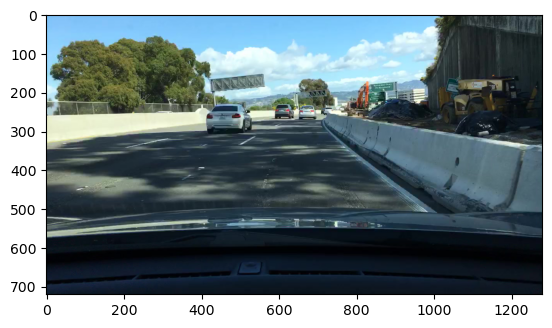

In [50]:
img_init = imread(test_file_names[0])
plt.imshow(img_init)
N = len(test_file_names)

h, w = img_init.shape[0], img_init.shape[1]
print(h,w)
print(f"The test dataset has {N} images")

## Training the model

In [51]:
# Train on the whole dataset :

clf_128 = svm.SVC()
clf_128.fit(X_128, y_128)

SVC()

In [52]:
clf_64 = svm.SVC()
clf_64.fit(X_64, y_64)

SVC()

In [80]:
confidence_threshold = 0.5
predicted_cars_128 = []

start = time.time()

for k in tqdm(range(N)):

    img_init = imread(test_file_names[k])
    pred = []
    for x in range(0, h-128, 32):
        for y in range(0, w-128, 32):
            img = img_init[x:x+128, y:y+128, :]
            fd = get_hog_features_function(img, 8, 16, 1, False)
            score = clf_128.decision_function([fd])[0]
            y_pred = clf_128.predict([fd])
            if y_pred==1 and score>=confidence_threshold:
                pred.append([x,y, x+128, y+128])

    predicted_cars_128.append(pred)
    """ 
    fig, ax = plt.subplots(figsize=(10, 8))

    bbs = [(element[0], element[1]) for element in pred]

    for y, x in bbs:

        rect = patches.Rectangle((x, y), 128, 128, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        ax.imshow(img_init)
        ax.set_title('Annotations for frame {}.'.format(k))
      """
end = time.time()
print(f"Execution time is {round(end-start)} s")

100%|█████████████████████████████████████████| 202/202 [10:29<00:00,  3.12s/it]

Execution time is 630 s


In [84]:
confidence_threshold = 0.5
predicted_cars_64 = []

start = time.time()

for k in tqdm(range(N)):
    pred = []
    img_init = imread(test_file_names[k]) 
    #print(f"Running classification for image {k}")
    for x in range(0, h-64, 16):
        for y in range(0, w-64, 16):
            
            img = img_init[x:x+64, y:y+64, :]
            fd = get_hog_features_function(img, 8, 6, 1, False)
            score = clf_64.decision_function([fd])[0]
            y_pred = clf_64.predict([fd])
            if y_pred==1 and score >= confidence_threshold:
                    pred.append([x, y, x+64, y+64])
                    
    predicted_cars_64.append(pred)
""" 
    fig, ax = plt.subplots(figsize=(10, 8))

    bbs = [(element[0], element[1]) for element in pred]

    for y, x in bbs:

        rect = patches.Rectangle((x, y), 64, 64, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        ax.imshow(img_init)
        ax.set_title('Annotations for frame {}.'.format(k))
    
"""                   
end = time.time()
print(f"Executed in {round(end-start)} s")

100%|█████████████████████████████████████████| 202/202 [58:30<00:00, 17.38s/it]

Executed in 3511 s


In [125]:
predicted_cars_df = []
for k in range(N):
    temp = predicted_cars_64[k] + predicted_cars_128[k]

    predicted_cars_df.append(temp)

In [113]:
H, W = 720, 1280

test_files = sorted(os.listdir('./test/'))

rows = []

for k, file_name in enumerate(test_files):
    
    
    bounding_boxes = predicted_cars_df[k]
    bounding_boxes_adapted = [ [elem[1], elem[0], elem[2]-elem[0], elem[3]-elem[1]] for elem in  bounding_boxes]
    rle = run_length_encoding(bounding_boxes_to_mask(bounding_boxes_adapted, H, W))

    rows.append(['test/' + file_name, rle])

df_prediction = pd.DataFrame(columns=['Id', 'Predicted'], data=rows).set_index('Id')
df_prediction.to_csv('submission_3.csv')

### Showing some results 

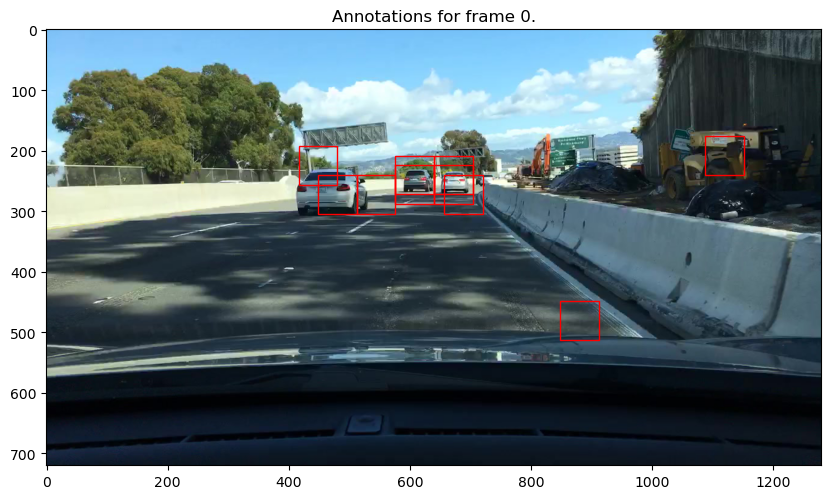

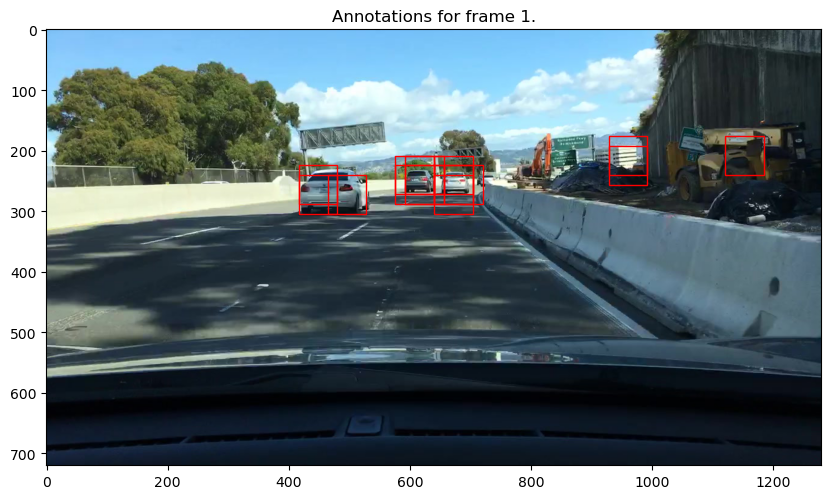

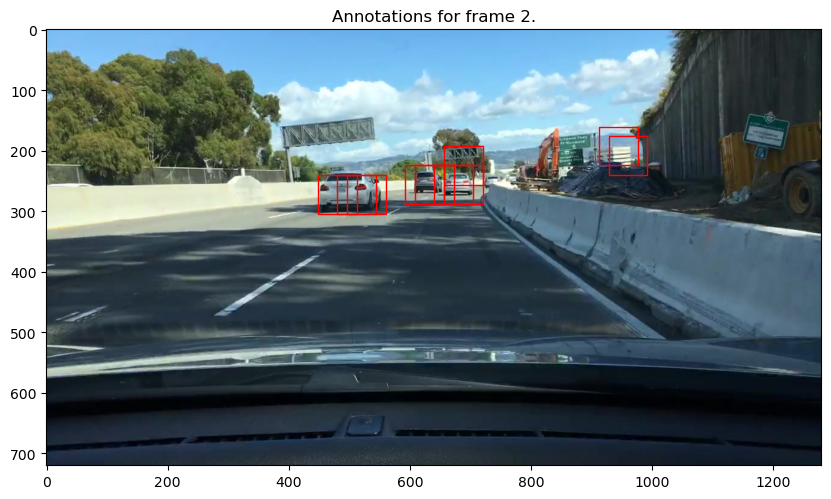

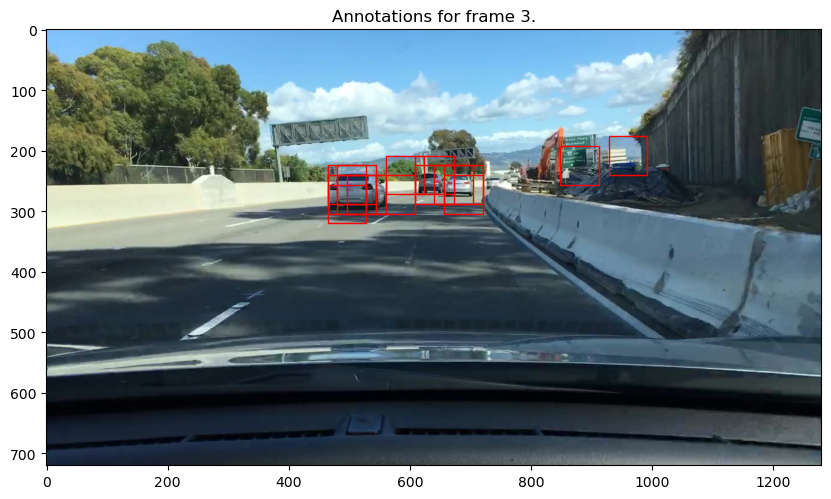

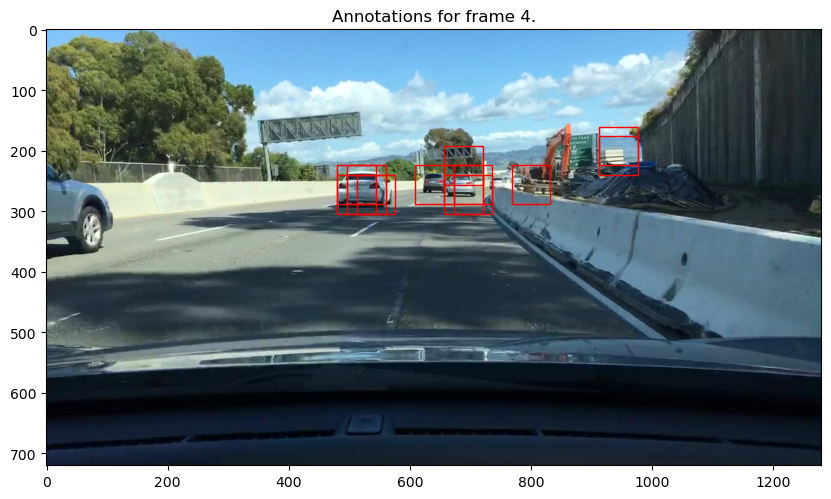

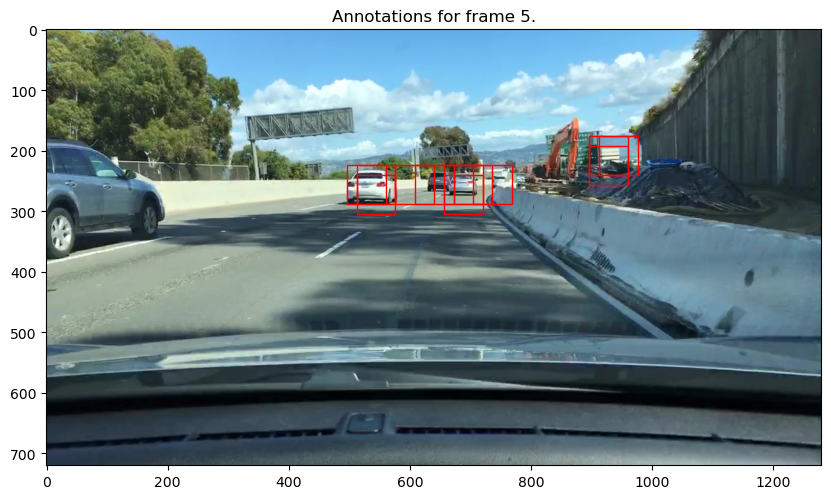

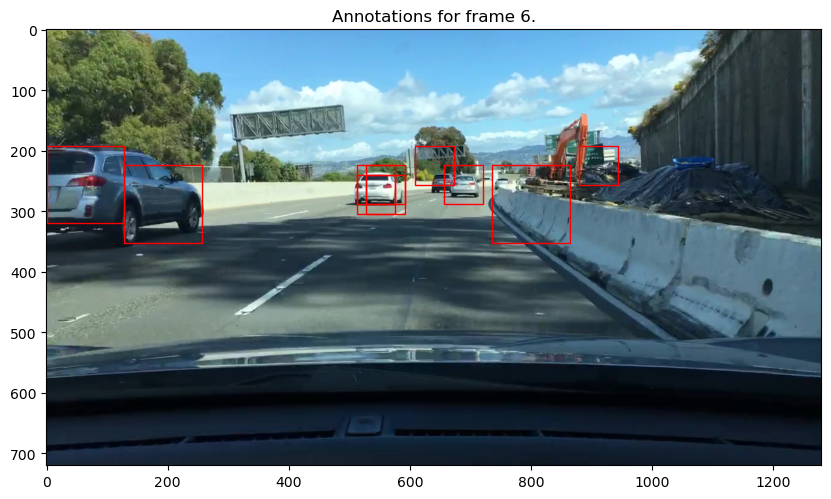

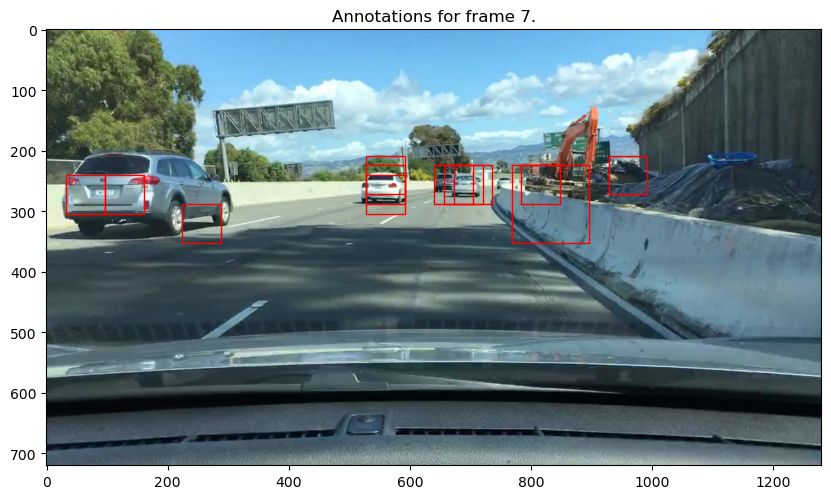

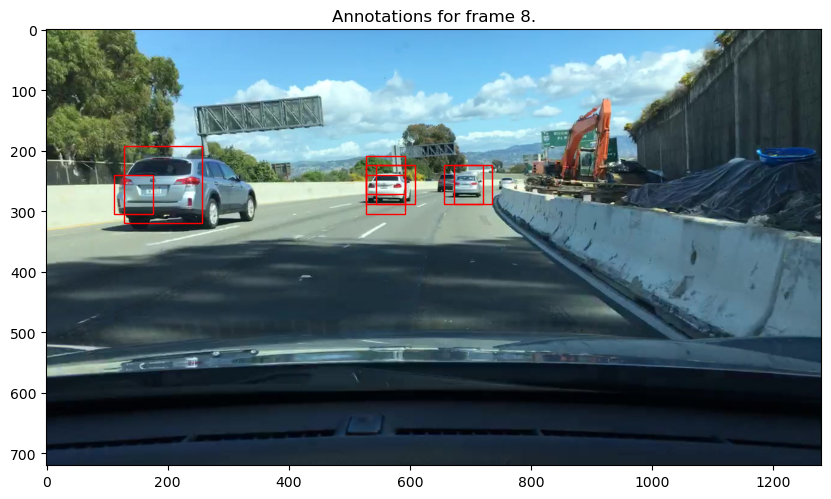

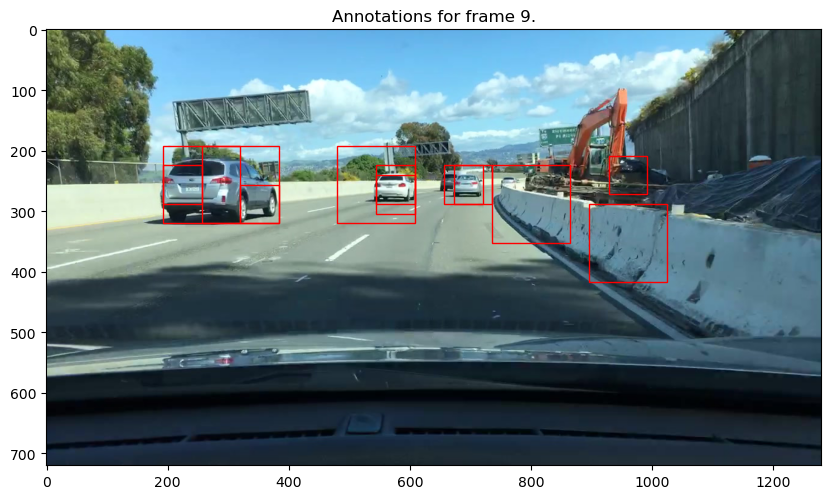

In [127]:
for k in range(10):

    fig, ax = plt.subplots(figsize=(10, 8))
    img_init = imread(test_file_names[k])

    bbs = [(element[0], element[1], element[2], element[3]) for element in predicted_cars_df[k][1:]]

    for y1, x1, y2, x2  in bbs:
        width = x2-x1
        rect = patches.Rectangle((x1, y1), width, width, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        ax.imshow(img_init)
        ax.set_title('Annotations for frame {}.'.format(k))